# Simple

В этой среде один агент видит ориентир (**landmark**), и его вознаграждение определяется тем, насколько близко он подбирается к ориентиру. 

In [10]:
from pettingzoo.mpe import simple_v3

env = simple_v3.env(max_cycles=150, render_mode="rgb_array")
env.reset()

action_space = env.action_space("agent_0")
observation_space = env.observation_space("agent_0")

print(f"{ env.agents = }")
print(f"{ action_space = }")
print(f"{ observation_space = }")

 env.agents = ['agent_0']
 action_space = Discrete(5)
 observation_space = Box(-inf, inf, (4,), float32)


## Observation space

Агент может наблюдать 4 значения: первая пара значений – его собственная скорость (`self_vel`), вторая пара значений – позиция ориентира относительно агента (`landmark_rel_position`).

In [11]:
observation = env.observe("agent_0")
self_vel, landmark_rel_position = observation[:2], observation[2:]
print(self_vel, landmark_rel_position)

[0. 0.] [-0.67672384 -1.12335   ]


## Action Space

Дейстиве определяется единственным числом, задающим направление ускорения:

- 0 – без ускорения ;
- 1 – ускорение влево;
- 2 – ускорение вправо;
- 3 – ускорение вниз;
- 4 – ускорение вверх.

> При движении без ускорения скорость постепенно падает, а при постоянном ускорении вдоль одной из осей максимальная скорость ограничивается значением `2.0`.

In [12]:
action_space.sample()   # случайное значение действия

3

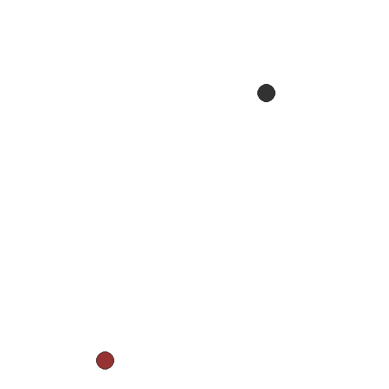

In [13]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(env.render())

In [14]:
env.step(1)
observation = env.observe("agent_0")
self_vel, landmark_rel_position = observation[:2], observation[2:]
print(self_vel, landmark_rel_position)

[-0.5  0. ] [-0.67672384 -1.12335   ]


## Rewards

Вознаграждение на каждом шаге определяется отрицательным значением квадрата евклидова расстояния агента до ориентира:

In [15]:
print(env.rewards)
landmark_rel_position[0]**2 + landmark_rel_position[1]**2

{'agent_0': -1.7198704141806709}


1.7198704296403378

## AEC API

Запустим Agent Environment Cycle ([AEC](https://pettingzoo.farama.org/api/aec/)) с хаотическими действиями. При запуске AEC действия агентов совершаются по очерди: в одной итерации совершается действие одного агента, на следующей итерации – действие второго агента и тд. Таким образом, агенты перебираются циклически.

Метод `last()` возвращает значения для текущего агента, соответствующие его последнему действию.

In [16]:
env = simple_v3.env(render_mode="human")
env.reset(seed=42)

for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()
    if termination or truncation:
        action = None
    else:
        action = env.action_space(agent).sample() # this is where you would insert your policy

    env.step(action)
env.close()

## Parallel API

Параллельный запуск позволяет произвести действия для всех агентов в одной итерации. Для этого во внутреннем цикле (dict comprehension) перебираются агенты, и для каждого агента выбирается действие из его action space. Сформированный таким образом словарь (agent: action) передается методу `step()`, который возвращает значения для всех агентов, после их действий.

In [17]:
parallel_env = simple_v3.parallel_env(render_mode="human")
observations, infos = parallel_env.reset(seed=42)

while parallel_env.agents:
    actions = {agent: parallel_env.action_space(agent).sample() for agent in parallel_env.agents}
    observations, rewards, terminations, truncations, infos = parallel_env.step(actions)
parallel_env.close()

In [18]:
import numpy as np

a, b = [0, 1, 2], [3, 4, 5]
np.concatenate([a, b])

array([0, 1, 2, 3, 4, 5])

In [19]:
observations

{'agent_0': array([-7.9064537e-04,  1.0859103e+00, -4.3103251e-01,  1.5134330e-01],
       dtype=float32)}

# Policy

In [20]:
def simple_plicy(observation):
    vx, vy, landmark_x, landmark_y = observation
    if landmark_x > 0:
        if vx < 1.0:
            return 2
    else:
        if vx > -1.0:
            return 1
    if landmark_y > 0:
        if vy < 1.0:
            return 4
    else:
        if vy > -1.0:
            return 3
    return 0        

In [ ]:
parallel_env = simple_v3.parallel_env(max_cycles=25, render_mode="human")
observations, infos = parallel_env.reset(seed=42)

while parallel_env.agents:
    actions = {agent: simple_plicy(observations["agent_0"]) for agent in parallel_env.agents}
    observations, rewards, terminations, truncations, infos = parallel_env.step(actions)
parallel_env.close()